In [355]:
# Install a pip package in the current Jupyter kernel
import sys
os.environ["TOKENIZERS_PARALLELISM"] = "false"

!{sys.executable} -m pip install openpyxl tensorflow seaborn --quiet

You should consider upgrading via the '/Users/lblachnicki/ml/my_env/bin/python3 -m pip install --upgrade pip' command.


In [351]:
import os
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from scipy.stats import uniform, expon
from scipy.stats import probplot

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import matplotlib.pyplot as plt
%matplotlib inline

## Design and implement a data preprocessing pipeline

(414, 6) (414,)


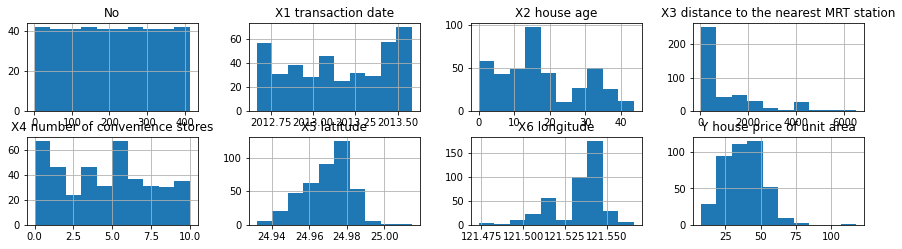

In [604]:
notebook_path = os.path.abspath("Solution.ipynb")
source_path = os.path.join(os.path.dirname(notebook_path), "datasets/regression/Real estate valuation data set.xlsx")
df = pd.read_excel(source_path,engine='openpyxl')

df.hist(layout=(5,4), figsize=(15,10))

data = df.values

X, y = data[:, :-1], data[:, -1]

# remove first column - "No"
X = X[:,1:]

print(X.shape, y.shape)

In [605]:
# split into test and train sets
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(249, 6) (137, 6) (249,) (137,)


In [606]:
# identify outliers in the training dataset
lof = LocalOutlierFactor(contamination=0.1)
outlier_pred = lof.fit_predict(X_train)

mask = outlier_pred != -1

In [614]:
outliersX, outliersY = X_train_raw[np.invert(mask), :], y_train_raw[np.invert(mask)]
X_train, y_train = X_train_raw[mask, :], y_train_raw[mask]

outlier_index = np.where(outlier_pred == -1)

fig, axes = plt.subplots(2, 3, figsize=(14,4), sharey='row')

axes = axes.ravel()

for i in range(6):
    ax = axes[i]
    
    ax.scatter(x=outliersX[:,i], y=outliersY, color='red', label='outliers')
    ax.scatter(x=X_train[:,i], y=y_train, label='inliers')
    
    ax.set_ylabel(df.columns[-1])
    ax.set_xlabel(df.columns[i])

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.subplots_adjust(bottom=-.5)
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 277 but corresponding boolean dimension is 249

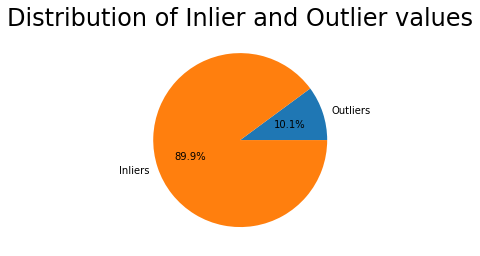

In [609]:
plt.pie(
    [len(outliersX), len(X_train)],
    labels = ['Outliers', 'Inliers'],
    autopct='%1.1f%%',
)
plt.title('Distribution of Inlier and Outlier values', size=24)
plt.show() 

In [550]:
# select all rows that are not outliers

# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

# fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# evaluate the model
model_pred = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, model_pred)
print('MAE: %.3f' % mae)

(277, 6) (277,)
MAE: 6.284


In [ ]:
# https://www.analyticsvidhya.com/blog/2020/01/build-your-first-machine-learning-pipeline-using-scikit-learn/

# contains decent steps
# https://github.com/collindching/Learning-Exercises/tree/master/Box%20Office%20Revenue%20Prediction

# todo use scatterplots to find and remove outliers
# todo standardize?

# nothing null, no need for IMPUTERS
print(np.where(pd.isnull(data)))



# separate X and Y values
train_x = data.drop(columns=['Y house price of unit area'])
train_y = data['Y house price of unit area']

pre_process = ColumnTransformer(
    remainder='passthrough',
    transformers=[('drop_columns', 'drop', ['No'])],
)

# Define the Pipeline
"""
Step1: get the oultet binary columns
Step2: pre processing
Step3: Train a Random Forest Model
"""
model_pipeline = Pipeline(steps=[('pre_processing',pre_process),
                                 ('random_forest', RandomForestRegressor(max_depth=10,random_state=2))
                                 ])
# fit the pipeline with the training data
model_pipeline.fit(train_x,train_y)

# predict target values on the training data
print(model_pipeline.predict(train_x))

# print(train_x)
# print(train_y)

# Classification

In [ ]:
notebook_path = os.path.abspath("Solution.ipynb")

amazon_source_path = os.path.join(os.path.dirname(notebook_path), "datasets/classification/amazon_cells_labelled.txt")
imdb_source_path = os.path.join(os.path.dirname(notebook_path), "datasets/classification/imdb_labelled.txt")
yelp_source_path = os.path.join(os.path.dirname(notebook_path), "datasets/classification/yelp_labelled.txt")

datasets = {
    'amazon': pd.read_csv(amazon_source_path, delimiter='\t', header=None, names=["text","label"]),
    'imdb': pd.read_csv(imdb_source_path, delimiter='\t', header=None, names=["text","label"]),
    'yelp': pd.read_csv(yelp_source_path, delimiter='\t', header=None, names=["text","label"]),
}

for dataset in datasets:
    print(f"Dataset {str(dataset)}:")
    print("Shape: " + str(datasets[dataset].shape))
    print(datasets[dataset].head())
    print(datasets[dataset].info())
    print(datasets[dataset].describe())
    print("--------------------------------------------------\n")


In [ ]:
# merge datasets
datasets["amazon"]["source"] = 'amazon'
datasets["imdb"]["source"] = 'imdb'
datasets["yelp"]["source"] = 'yelp'

data = pd.concat(list(datasets.values()))

data.shape

In [ ]:
data['source'].value_counts().plot(kind='pie', 
                                   autopct='%1.0f%%',
                                   shadow=True, 
                                   startangle=90, 
                                   pctdistance=0.85,
                                   explode = (0.1,0.1,0.1),
                                   colors = ['#f19100','#f21919','#e2b616'],
                                   figsize=(5, 5))

In [ ]:
data.label.value_counts().plot(kind='pie', 
                                   autopct='%1.0f%%',
                                   shadow=True, 
                                   startangle=180, 
                                   pctdistance=0.85,
                                   explode = (0.05,0.05),
                                   colors = ['#5cb696','#e4565c'],
                                   figsize=(5, 5))

## Preprocessing

In [ ]:
sentences = data['text'].values
y = data['label'].values

# diviser les données
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, 
                                                                    test_size=0.25, 
                                                                    random_state=1000, 
                                                                    shuffle=True)
train_sentences = np.array(sentences_train)
train_labels = np.array(y_train)
train = pd.DataFrame({'label': train_labels, 'text': list(train_sentences)}, columns=['label', 'text'])

# verifying that trianing set is split evenly
train.label.value_counts().plot(kind='pie', 
                                   autopct='%1.0f%%',
                                   shadow=True, 
                                   startangle=180, 
                                   pctdistance=0.85,
                                   explode = (0.05,0.05),
                                   colors = ['#5cb696','#e4565c'],
                                   figsize=(5, 5))

## Vectorization of text

In [ ]:
sample_text = data['text'][:3]
for text in sample_text: print(text)
    
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sample_text)
vectorizer.vocabulary_



In [ ]:
vectorizer.transform(sample_text).toarray()

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

vectorizer.vocabulary_

In [ ]:
def prediction(model_name):
    for dataframe in datasets.values():
        Sentences = dataframe['text'].values
        Y = dataframe['label'].values

        Sentences_train, Sentences_test, Y_train, Y_test = train_test_split(
            Sentences, Y, test_size=0.25, random_state=1000)
        vectorizer = CountVectorizer(stop_words='english')
        vectorizer.fit(sentences_train)
        x_train = vectorizer.transform(Sentences_train)
        x_test  = vectorizer.transform(Sentences_test)

        model = models[model_name]
        model.fit(x_train, Y_train)
        score = model.score(x_test, Y_test)
        print('Accuracy for {} data with {} model is: {:.2f} %'.format(dataframe['source'][0],model_name, (score*100)))
    print('\n'+('-'*70)+'\n')
    
    
models = {"Logistic Regression": LogisticRegression(),
          "Support Vector Machine": SVC(),
          "Decision Tree": DecisionTreeClassifier(),
          "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, max_depth=100, random_state=5000),
          "Random Forest": RandomForestClassifier(max_depth=200, random_state=1000)
         }

for model in models: prediction(model)

In [ ]:
description = "hello man nice bad awful"

desc = vectorizer.transform([description])


Sentences = data['text'].values
Y = data['label'].values

model = SVC()
Sentences_train, Sentences_test, Y_train, Y_test = train_test_split(
    Sentences, Y, test_size=0.25, random_state=1000)
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(sentences_train)
x_train = vectorizer.transform(Sentences_train)
x_test  = vectorizer.transform(Sentences_test)

model.fit(x_train, Y_train)
score = model.score(x_test, Y_test)
print('Accuracy is: {:.2f} %'.format((score*100)))
print('\n'+('-'*70)+'\n')

model.predict(desc)
#https://www.kaggle.com/code/kobeerose/sentiment-analysis


# Clustering

In [ ]:
notebook_path = os.path.abspath("Solution.ipynb")
# https://www.kaggle.com/code/jackfroster/heart-failure-prediction-clustering-approach
source_path = os.path.join(os.path.dirname(notebook_path), "datasets/clustering/heart_failure_clinical_records_dataset.csv")

df = pd.read_csv(source_path)

# print(df)

df.hist(layout=(5,4), figsize=(15,10))

In [ ]:
import seaborn as sns

plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True);

In [ ]:


X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=3)

pipe = Pipeline(steps=[("scaler", StandardScaler()), ("estimator", LogisticRegression())])

grid = {
    'estimator__penalty': ['l1', 'l2'],
    'estimator__C': np.logspace(-3,3,10),
    'estimator__class_weight': ['balanced', None],
    'estimator__solver': ['liblinear', 'saga'],
}

logreg_cv = GridSearchCV(pipe, grid, cv=10, verbose=0, n_jobs=-1)
logreg_cv.fit(X_train, y_train)
print("best hyperparameters:",logreg_cv.best_params_)
print("score:",logreg_cv.best_score_)

# In case of linear model (Logistic Regression,Linear Regression, Regularization) we generally find coefficient to predict the output.let’s understand it by code.
importance=logreg_cv.best_estimator_['estimator'].coef_[0]
importance=np.exp(importance)

result = np.array(list(zip(df.columns.values, importance)))
result=result[np.argsort(result[:, 1])]
print(result)

d = dict({
    'age': 20,
    'anaemia': 1,
    'creatinine_phosphokinase': 80,
    'diabetes': 0,
    'ejection_fraction': 30,
    'high_blood_pressure': 1,
    'platelets': 427000,
    'serum_creatinine': 1,
    'serum_sodium': 138,
    'sex': 0,
    'smoking': 0,
    'time': 12,
})

prediction = logreg_cv.predict(np.array(list(d.values())).reshape(1,-1))
print('alive' if prediction[0] == 0 else 'dead')

# # https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1
# for label, value in result:
#     print("Feature: {} has importance: {} ".format(label,value))

